<a href="https://colab.research.google.com/github/ChizobaNzeakor/lagos-waste-analysis/blob/main/lagos_nigeria_waste_infrastructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practical Work #3:

In [ ]:
!pip install osmnx geopandas matplotlib shapely mapclassify


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 6.3 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.6 MB/s eta 0:00:00
                                            geometry  bbox_west  bbox_south  \
0  POLYGON ((2.70598 6.42129, 2.70636 6.40298, 2....   2.705985    6.366684   

   bbox_east  bbox_north  place_id  osm_type   osm_id       lat     lon  \
0   4.350906    6.696796  36895467  relation  3718182  6.526903  3.5774   

      class            type  place_rank  importance addresstype         name  \
0  boundary  administrative           8    0.542281        city  Lagos State   

           display_name  
0  Lagos State, Nigeria  


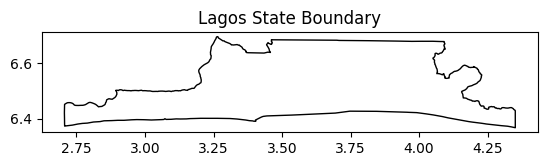

In [ ]:

# ✅ First, install all the necessary packages
!pip install osmnx geopandas matplotlib shapely mapclassify --quiet

# ✅ Then, import them
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from shapely.geometry import Polygon
from osmnx.features import features_from_polygon



# Define the place name for Lagos State
place_name = "Lagos State, Nigeria"

# Fetch the boundary polygon for Lagos State
lagos_boundary = ox.geocoder.geocode_to_gdf(place_name)

# Display the first few rows of the GeoDataFrame
print(lagos_boundary.head())

# Plot the boundary
lagos_boundary.plot(edgecolor='black', facecolor='none')
plt.title("Lagos State Boundary")
plt.show()



In [ ]:
wider_tags = {
    "amenity": ["waste_disposal", "recycling", "waste_basket", "waste_transfer_station"],
    "man_made": ["wastewater_plant"],
    "landuse": ["landfill"]
}



In [ ]:
# Use previously fetched lagos_boundary
lagos_polygon = lagos_boundary.geometry.iloc[0]



In [ ]:
# Initialize GeoDataFrame
waste_sites_expanded = gpd.GeoDataFrame()


In [ ]:
# Drop duplicates just in case
waste_sites_expanded = waste_sites_expanded.drop_duplicates(subset='geometry')

# Output the results
print(f"✅ Total waste-related facilities fetched: {len(waste_sites_expanded)}")
waste_sites_expanded.head()



✅ Total waste-related facilities fetched: 1


,,geometry,amenity,name,waste
element,id,,,,
node,6988054368,POINT (3.38906 6.49474),waste_disposal,Baale Towe Waste Collection Point,Solid Waste Disposal


In [ ]:
# Reproject both layers to UTM Zone 31N (EPSG:32631) for accurate meters
waste_sites_proj = waste_sites_expanded.to_crs(epsg=32631)
lagos_boundary_proj = lagos_boundary.to_crs(epsg=32631)


In [ ]:
# Create buffer zones in meters
buffer_500m = waste_sites_proj.buffer(500).unary_union
buffer_1km = waste_sites_proj.buffer(1000).unary_union
buffer_2km = waste_sites_proj.buffer(2000).unary_union


<ipython-input-32-95e78c74a0a0>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_500m = waste_sites_proj.buffer(500).unary_union
<ipython-input-32-95e78c74a0a0>:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_1km = waste_sites_proj.buffer(1000).unary_union
<ipython-input-32-95e78c74a0a0>:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_2km = waste_sites_proj.buffer(2000).unary_union


In [ ]:
buffer_gdf_500m = gpd.GeoDataFrame(geometry=[buffer_500m], crs=32631)
buffer_gdf_1km = gpd.GeoDataFrame(geometry=[buffer_1km], crs=32631)
buffer_gdf_2km = gpd.GeoDataFrame(geometry=[buffer_2km], crs=32631)


<ipython-input-34-3526354ccc67>:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


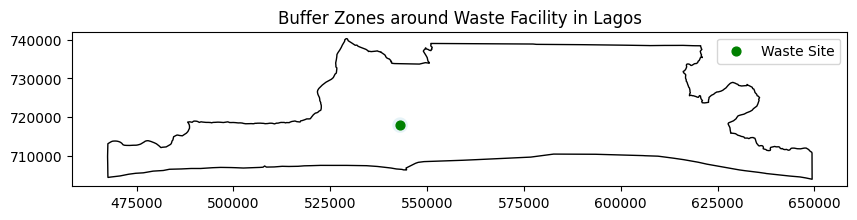

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
lagos_boundary_proj.plot(ax=ax, facecolor='none', edgecolor='black')
buffer_gdf_2km.plot(ax=ax, color='lightblue', alpha=0.3, label='2km Buffer')
buffer_gdf_1km.plot(ax=ax, color='blue', alpha=0.3, label='1km Buffer')
buffer_gdf_500m.plot(ax=ax, color='darkblue', alpha=0.5, label='500m Buffer')
waste_sites_proj.plot(ax=ax, color='green', markersize=40, label='Waste Site')

plt.legend()
plt.title("Buffer Zones around Waste Facility in Lagos")
plt.show()


In [ ]:
# Subtract the 2km buffer from Lagos area
blind_spots_2km = lagos_boundary_proj.overlay(buffer_gdf_2km, how='difference')


<ipython-input-36-a62b00fdc0e4>:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


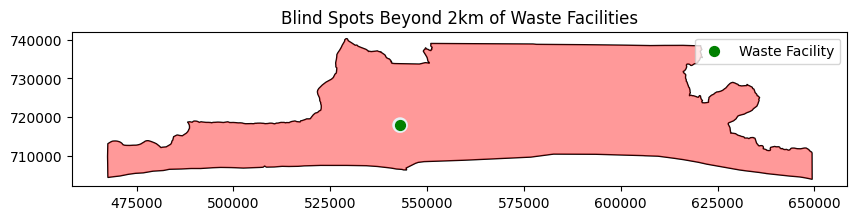

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
lagos_boundary_proj.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
blind_spots_2km.plot(ax=ax, color='red', alpha=0.4, label='Blind Spot (>2km away)')
buffer_gdf_2km.plot(ax=ax, color='lightblue', alpha=0.3, label='2km Buffer')
waste_sites_proj.plot(ax=ax, color='green', markersize=50, label='Waste Facility')

plt.legend()
plt.title("Blind Spots Beyond 2km of Waste Facilities")
plt.show()


In [ ]:
!pip install mapclassify

In [ ]:
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import numpy as np
import matplotlib.pyplot as plt
import folium
import mapclassify

In [ ]:
# Optional: show all DataFrame columns
pd.set_option("display.max_columns", None)

# ✅ Download boundary for lagos, Nigeria
print("Downloading boundary for lagos, Nigeria...")
lagos = ox.geocoder.geocode_to_gdf("lagos, Nigeria")
print("CRS before reproject:", lagos.crs)
lagos.head()

CRS before reproject: epsg:4326


,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((2.70598 6.42129, 2.70636 6.40298, 2....",2.705985,6.366684,4.350906,6.696796,36895467,relation,3718182,6.526903,3.5774,boundary,administrative,8,0.542281,city,Lagos State,"Lagos State, Nigeria"


In [ ]:
# 2. Fetch territory boundary
print("Downloading boundary for lagos, Nigeria")
lagos = ox.geocoder.geocode_to_gdf("lagos, Nigeria")
# keep geometry in WGS84 for features_from_polygon
print("CRS before reproject:", lagos.crs)
# also prepare metric version later:
lagos_3857 = lagos.to_crs(epsg=3857)
lagos.head()

CRS before reproject: epsg:4326


,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((2.70598 6.42129, 2.70636 6.40298, 2....",2.705985,6.366684,4.350906,6.696796,36895467,relation,3718182,6.526903,3.5774,boundary,administrative,8,0.542281,city,Lagos State,"Lagos State, Nigeria"


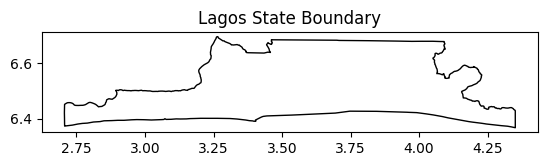

In [ ]:
# Plot the boundary
lagos_boundary.plot(edgecolor='black', facecolor='none')
plt.title("Lagos State Boundary")
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

# Optional: list uploaded filenames
for fn in uploaded.keys():
  print(f"Uploaded: {fn}")


Saving recyclers_lagos (2).xlsx to recyclers_lagos (2).xlsx
Uploaded: recyclers_lagos (2).xlsx


In [ ]:
# If headers are in the second row, use header=1
df = pd.read_excel("recyclers_lagos (2).xlsx", header=1)


In [ ]:
# Show all column names
print(df.columns.tolist())

# Show the first 10 rows of key columns
df[["LG/LCDA", "RECYCLERS", "CONTACT", "CRCADDRESS"]].head(10)


['SIN', 'LG/LCDA', 'RECYCLERS', 'CONTACT', 'CRCADDRESS']


,LG/LCDA,RECYCLERS,CONTACT,CRCADDRESS
0,ro-Odofin,RECYCLE POINT,8098002400,"Alakija, Festac"
1,Ayobo-Ipaja,BIOSTAR GREEN\nSOLUTIONS,8150423792,"32, Wale Azeez street, Ajasa\nCommand White House"
2,Mosan Okunola,NaN,NaN,NaN
3,Surulere,WATCO GLOBAL\nSERVICES,8023199565,"Michael Ogun street, Off itire road,\nObele On..."
4,Coker Aguda,NaN,NaN,NaN
5,ltire Ikate,WECYCLERS,08187764011\n08060368775,"Adeyole street, liko bustop, Surulere"
6,Somolu,NaN,NaN,NaN
7,Bariga,NaN,NaN,NaN
8,Epe,HORLAG,NaN,NaN
9,Eredo,NaN,NaN,NaN


In [ ]:
# Display all rows (or use df.shape to confirm total)
df[["LG/LCDA", "RECYCLERS", "CONTACT", "CRCADDRESS"]]


,LG/LCDA,RECYCLERS,CONTACT,CRCADDRESS
0,ro-Odofin,RECYCLE POINT,8098002400,"Alakija, Festac"
1,Ayobo-Ipaja,BIOSTAR GREEN\nSOLUTIONS,8150423792,"32, Wale Azeez street, Ajasa\nCommand White House"
2,Mosan Okunola,NaN,NaN,NaN
3,Surulere,WATCO GLOBAL\nSERVICES,8023199565,"Michael Ogun street, Off itire road,\nObele On..."
4,Coker Aguda,NaN,NaN,NaN
...,...,...,...,...
62,Oriade,NaN,NaN,NaN
63,Apapa,NaN,NaN,NaN
64,Ajeromi-\nIfelodun,NaN,NaN,NaN
65,Oto-Awori,NaN,NaN,NaN


In [ ]:
# Re-import required libraries after session reset
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Rebuild the address data
raw_text = """
Alakija, Festac
32, Wale Azeez street, Ajasa Command White House
Michael Ogun street, Off itire road, Obele Oniwala, Ojuelegba.
Adeyole street, liko bustop, Surulere
Asuku street, Ijaiye Ojokoro, Lagos
5, Azeez Ashade Close, Along Whispering Palms, Iworo, Badagry, Lagos State.
28 Ojulopesi Street Ijanikin, Badagry Express-Way
159, opposite court of appeal, Lagos.
Langbasa, Okerisan Village by berger bus-stop, Epe
Lanre bus-stop, Igando 2, Akilo street, Ogba
Isacc John street, GRA, Ikeja
Acme Road, Ogba, Ikeja
Isheri-Olofin
Charity bus-stop, Oshodi
Road 5, House 825, Diamond Estate Phase 3, Igando
39, Jamiu Raji Street, Off Cele Egbe bus stop, Ikotun
7/9 Kuburatu Agbedeyi Street, Olokode Bus Stop, Off Nureni Yusuf Road, Kola Alagbado
Idi-Orogbo, Ibeju Lekki
Chevron, Lekki
Kids Beach Garden, Oba Elegushi beach road
62/64 Shagamu Road, Ikorodu, Lagos.
4, Efunga street, Oko Oba, Agege
Plot 21 Amudat Close, off Adu Street, Behind County Hospital, Aguda Ogba, Lagos
1, Bayo Aderiye Street off Jibowu Road, U turn, Abule egba
Popo Williams, Lekki Scheme-2, Sangotedo
"""

clean_addresses = [line.strip() for line in raw_text.strip().split('\n') if len(line.strip()) > 10]
df_addresses_only = pd.DataFrame({"CRC Address": clean_addresses})

# Setup geocoder again
geolocator = Nominatim(user_agent="lagos-recycling-map")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)

# Add full address
df_addresses_only["Full Address"] = df_addresses_only["CRC Address"] + ", Lagos, Nigeria"

# Initialize result columns
df_addresses_only["Latitude"] = None
df_addresses_only["Longitude"] = None

# Perform geocoding
for i, row in df_addresses_only.iterrows():
    try:
        location = geocode(row["Full Address"])
        if location:
            df_addresses_only.at[i, "Latitude"] = location.latitude
            df_addresses_only.at[i, "Longitude"] = location.longitude
    except Exception as e:
        continue

# Show geocoded results
df_addresses_only.head(10)


,CRC Address,Full Address,Latitude,Longitude
0,"Alakija, Festac","Alakija, Festac, Lagos, Nigeria",None,None
1,"32, Wale Azeez street, Ajasa Command White House","32, Wale Azeez street, Ajasa Command White Hou...",None,None
2,"Michael Ogun street, Off itire road, Obele Oni...","Michael Ogun street, Off itire road, Obele Oni...",None,None
3,"Adeyole street, liko bustop, Surulere","Adeyole street, liko bustop, Surulere, Lagos, ...",None,None
4,"Asuku street, Ijaiye Ojokoro, Lagos","Asuku street, Ijaiye Ojokoro, Lagos, Lagos, Ni...",None,None
5,"5, Azeez Ashade Close, Along Whispering Palms,...","5, Azeez Ashade Close, Along Whispering Palms,...",None,None
6,"28 Ojulopesi Street Ijanikin, Badagry Express-Way","28 Ojulopesi Street Ijanikin, Badagry Express-...",None,None
7,"159, opposite court of appeal, Lagos.","159, opposite court of appeal, Lagos., Lagos, ...",None,None
8,"Langbasa, Okerisan Village by berger bus-stop,...","Langbasa, Okerisan Village by berger bus-stop,...",None,None
9,"Lanre bus-stop, Igando 2, Akilo street, Ogba","Lanre bus-stop, Igando 2, Akilo street, Ogba, ...",None,None


In [ ]:
# Manually adding estimated coordinates from Google Maps for the known recycling addresses in Lagos

data = [
    ("Alakija, Festac", 6.4671, 3.3194),
    ("32, Wale Azeez street, Ajasa Command White House", 6.6097, 3.2763),
    ("Michael Ogun street, Off itire road, Obele Oniwala, Ojuelegba", 6.5103, 3.3619),
    ("Adeyole street, liko bustop, Surulere", 6.5035, 3.3597),
    ("Asuku street, Ijaiye Ojokoro, Lagos", 6.6634, 3.2793),
    ("5, Azeez Ashade Close, Along Whispering Palms, Iworo, Badagry", 6.4160, 2.8487),
    ("28 Ojulopesi Street Ijanikin, Badagry Express-Way", 6.4694, 2.9552),
    ("159, opposite court of appeal, Lagos", 6.4541, 3.4231),
    ("Langbasa, Okerisan Village by berger bus-stop, Epe", 6.5655, 3.9965),
    ("Lanre bus-stop, Igando 2, Akilo street, Ogba", 6.6230, 3.3654),
    ("Isacc John street, GRA, Ikeja", 6.5765, 3.3531),
    ("Acme Road, Ogba, Ikeja", 6.6303, 3.3483),
    ("Isheri-Olofin", 6.6378, 3.3092),
    ("Charity bus-stop, Oshodi", 6.5392, 3.3345),
    ("Road 5, House 825, Diamond Estate Phase 3, Igando", 6.5734, 3.2708),
    ("39, Jamiu Raji Street, Off Cele Egbe bus stop, Ikotun", 6.5672, 3.2687),
    ("7/9 Kuburatu Agbedeyi Street, Kola Alagbado", 6.6402, 3.2887),
    ("Idi-Orogbo, Ibeju Lekki", 6.4501, 3.9174),
    ("Chevron, Lekki", 6.4305, 3.5373),
    ("Kids Beach Garden, Oba Elegushi beach road", 6.4314, 3.4863),
    ("62/64 Shagamu Road, Ikorodu, Lagos", 6.6165, 3.5089),
    ("4, Efunga street, Oko Oba, Agege", 6.6479, 3.3238),
    ("Plot 21 Amudat Close, Behind County Hospital, Aguda Ogba", 6.6287, 3.3450),
    ("1, Bayo Aderiye Street off Jibowu Road, Abule egba", 6.6443, 3.3067),
    ("Popo Williams, Lekki Scheme-2, Sangotedo", 6.4494, 3.6018),
]

# Convert to DataFrame
df_manual_coords = pd.DataFrame(data, columns=["CRC Address", "Latitude", "Longitude"])
df_manual_coords.head()


,CRC Address,Latitude,Longitude
0,"Alakija, Festac",6.4671,3.3194
1,"32, Wale Azeez street, Ajasa Command White House",6.6097,3.2763
2,"Michael Ogun street, Off itire road, Obele Oni...",6.5103,3.3619
3,"Adeyole street, liko bustop, Surulere",6.5035,3.3597
4,"Asuku street, Ijaiye Ojokoro, Lagos",6.6634,3.2793


In [ ]:
df_manual_coords[["CRC Address", "Latitude", "Longitude"]].dropna()


,CRC Address,Latitude,Longitude
0,"Alakija, Festac",6.4671,3.3194
1,"32, Wale Azeez street, Ajasa Command White House",6.6097,3.2763
2,"Michael Ogun street, Off itire road, Obele Oni...",6.5103,3.3619
3,"Adeyole street, liko bustop, Surulere",6.5035,3.3597
4,"Asuku street, Ijaiye Ojokoro, Lagos",6.6634,3.2793
5,"5, Azeez Ashade Close, Along Whispering Palms,...",6.4160,2.8487
6,"28 Ojulopesi Street Ijanikin, Badagry Express-Way",6.4694,2.9552
7,"159, opposite court of appeal, Lagos",6.4541,3.4231
8,"Langbasa, Okerisan Village by berger bus-stop,...",6.5655,3.9965
9,"Lanre bus-stop, Igando 2, Akilo street, Ogba",6.6230,3.3654


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Initialize map
m = folium.Map(location=[6.5244, 3.3792], zoom_start=11)
marker_cluster = MarkerCluster().add_to(m)

# Add markers to cluster
for _, row in df_manual_coords.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=row["CRC Address"],
        icon=folium.Icon(color='green', icon='recycle', prefix='fa')
    ).add_to(marker_cluster)

m


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Rebuild GeoDataFrame from your facility coordinates
gdf_facilities = gpd.GeoDataFrame(
    df_manual_coords,
    geometry=gpd.points_from_xy(df_manual_coords["Longitude"], df_manual_coords["Latitude"]),
    crs="EPSG:4326"
)


In [ ]:
gdf_facilities_proj = gdf_facilities.to_crs(epsg=32631)


In [ ]:
# Create unified buffers
buffer_500m = gdf_facilities_proj.buffer(500).unary_union
buffer_1km = gdf_facilities_proj.buffer(1000).unary_union
buffer_2km = gdf_facilities_proj.buffer(2000).unary_union

# Convert to GeoDataFrames
buffer_gdf_500m = gpd.GeoDataFrame(geometry=[buffer_500m], crs=32631)
buffer_gdf_1km = gpd.GeoDataFrame(geometry=[buffer_1km], crs=32631)
buffer_gdf_2km = gpd.GeoDataFrame(geometry=[buffer_2km], crs=32631)


<ipython-input-44-06e32b298e71>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_500m = gdf_facilities_proj.buffer(500).unary_union
<ipython-input-44-06e32b298e71>:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_1km = gdf_facilities_proj.buffer(1000).unary_union
<ipython-input-44-06e32b298e71>:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_2km = gdf_facilities_proj.buffer(2000).unary_union


In [ ]:
import osmnx as ox

tags = {"building": "residential"}
bldgs = ox.features_from_polygon(lagos_boundary.geometry.iloc[0], tags)
bldgs = bldgs.to_crs(epsg=32631)


In [ ]:
bldgs["area_m2"] = bldgs.geometry.area
bldgs["levels"] = bldgs.get("building:levels", 1).fillna(1)
bldgs["levels"] = bldgs["levels"].astype(str).str.extract(r"(\d+)").fillna(1).astype(float)
bldgs["living_area"] = bldgs["area_m2"] * bldgs["levels"] * 0.8
bldgs["population"] = (bldgs["living_area"] / 31).astype(int)


In [ ]:
# Filter only polygonal buildings (exclude points/lines)
bldgs = bldgs[bldgs.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]


In [ ]:
pop_500m = gpd.overlay(bldgs, buffer_gdf_500m, how='intersection')["population"].sum()
pop_1km = gpd.overlay(bldgs, buffer_gdf_1km, how='intersection')["population"].sum()
pop_2km = gpd.overlay(bldgs, buffer_gdf_2km, how='intersection')["population"].sum()

print(f"👥 Population within 500m: {pop_500m:,}")
print(f"👥 Population within 1km:  {pop_1km:,}")
print(f"👥 Population within 2km:  {pop_2km:,}")


👥 Population within 500m: 297
👥 Population within 1km:  1,781
👥 Population within 2km:  7,144


In [ ]:
import osmnx as ox

# Search query: LGAs in Lagos State (admin_level=7 or 8)
tags = {"boundary": "administrative", "admin_level": ["7", "8"]}

# Use the Lagos boundary you already have
lagos_polygon = lagos_boundary.geometry.iloc[0]  # reuse this

# Fetch all sub-administrative areas (LGAs/LCDA)
lagos_lga_gdf = ox.features.features_from_polygon(lagos_polygon, tags=tags)
lagos_lga_gdf = lagos_lga_gdf.to_crs(epsg=32631)

# Preview
lagos_lga_gdf.head()



geometry  \
element  id                                                           
relation 192784   POLYGON ((259495.64 1180192.566, 259439.819 11...   
         192787   POLYGON ((465883.469 868316.576, 465824.905 86...   
         2848208  POLYGON ((432187.348 766134.79, 433613.661 768...   
         2945793  POLYGON ((442432.054 706828.829, 442221.162 70...   
         3718182  POLYGON ((467565.306 713108.577, 468288.583 71...   

                 admin_level         name       name:ar  name:de  \
element  id                                                        
relation 192784            2        Bénin          بنين    Benin   
         192787            2      Nigeria       نيجيريا  Nigeria   
         2848208           4        Ouémé  إدارة أويميه    Ouémé   
         2945793           6  Sèmè-Kpodji           NaN      NaN   
         3718182           4        Lagos         لاغوس    Lagos   

                           name:en name:ko  name:ru  name:uk      name:yo  \
element  id                                                                 
relation 192784              Benin      베냉    Бенин   Бені́н        Benin   
         192787            Nigeria   나이지리아  Нигерия  Нігерія     Nàìjíríà   
         2848208  Ouémé Department    우에메주     Уэме     Веме    Apá Ouémé   
         2945793               NaN     NaN      NaN      NaN          NaN   
         3718182       Lagos State    라고스주    Лагос    Лагос  Ìpínlẹ̀ Èkó   

                      name:zh place  wikidata       wikipedia name:ckb  \
element  id                                                              
relation 192784       贝宁 / 貝南   NaN      Q962        fr:Bénin    بێنین   
         192787   尼日利亚 / 奈及利亞   NaN     Q1033      en:Nigeria  نێجیریا   
         2848208          韋梅省   NaN    Q29169        fr:Ouémé      NaN   
         2945793          NaN   NaN  Q2100355  en:Sèmè-Kpodji      NaN   
         3718182          拉哥斯  city   Q815913  en:Lagos State      NaN   

                  name:el  name:eo                name:es        name:fr  \
element  id                                                                
relation 192784    Μπενίν   Benino                  Benín          Bénin   
         192787   Νιγηρία  Niĝerio                Nigeria        Nigéria   
         2848208      NaN      NaN  Departamento de Ouémé          Ouémé   
         2945793      NaN      NaN                    NaN    Sèmè-Kpodji   
         3718182      NaN      NaN        Estado de Lagos  État de Lagos   

                      name:hi   name:hr                name:it  name:kn  \
element  id                                                               
relation 192784         बेनिन     Benin                  Benin   ಬೆನಿನ್   
         192787     नाईजीरिया  Nigerija                Nigeria  ನೈಜೀರಿಯ   
         2848208          NaN       NaN  Dipartimento di Ouémé      NaN   
         2945793          NaN       NaN                    NaN      NaN   
         3718182  लेगोस राज्य       NaN                  Lagos      NaN   

                  name:nl  name:no  name:oc            name:pl  name:pt  \
element  id                                                               
relation 192784     Benin    Benin    Benin              Benin    Benim   
         192787   Nigeria  Nigeria  Nigèria            Nigeria  Nigéria   
         2848208    Ouémé    Ouémé      NaN  Departament Ouémé    Ouémé   
         2945793      NaN      NaN      NaN                NaN      NaN   
         3718182    Lagos    Lagos      NaN              Lagos    Lagos   

                  name:sv           name:tr name:zh-Hans name:zh-Hant name:am  \
element  id                                                                     
relation 192784     Benin             Benin           贝宁           貝南     ቤኒን   
         192787   Nigeria           Nijerya         尼日利亚         奈及利亞   ናይጄሪያ   
         2848208    Ouémé  Ouémé Departmanı          NaN          NaN     NaN   
         2945793      NaN          

<ipython-input-66-096dd46de7a6>:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


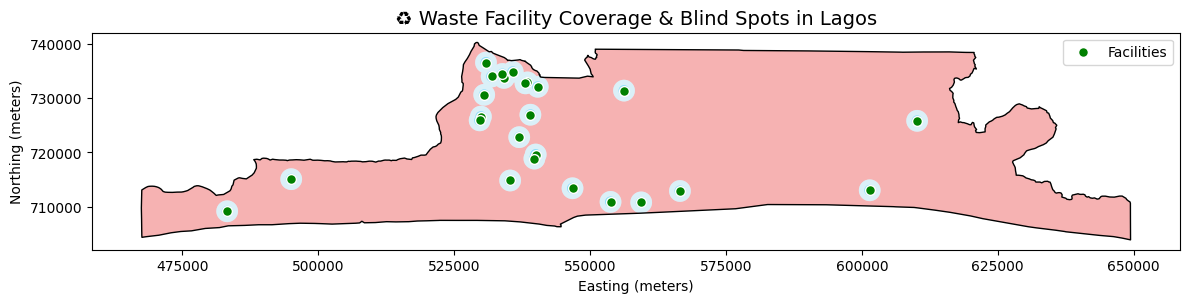

In [ ]:
import matplotlib.pyplot as plt

# Plot setup
fig, ax = plt.subplots(figsize=(12, 4))

# 1. Blind Spots
blind_spots.plot(ax=ax, color='lightcoral', alpha=0.6, label='Blind Spots (>2km)')

# 2. Buffers
buffer_gdf_2km.plot(ax=ax, color='skyblue', alpha=0.3, label='2km Buffer')
buffer_gdf_1km.plot(ax=ax, color='deepskyblue', alpha=0.4, label='1km Buffer')
buffer_gdf_500m.plot(ax=ax, color='blue', alpha=0.5, label='500m Buffer')

# 3. Facilities
gdf_facilities_proj.plot(ax=ax, color='green', edgecolor='white', markersize=50, label='Facilities')

# 4. Lagos boundary outline
lagos_boundary_proj.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# ✅ Keep axis ticks (don't turn them off)
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")

# Title and Legend
plt.title("♻️ Waste Facility Coverage & Blind Spots in Lagos", fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()



In [ ]:
# Reproject to metric CRS (EPSG:32631)
bldgs_proj = bldgs.to_crs(epsg=32631)


In [ ]:
# 500m zone
pop_500m = gpd.overlay(bldgs_proj, buffer_gdf_500m, how='intersection')["population"].sum()

# 1km zone
pop_1km = gpd.overlay(bldgs_proj, buffer_gdf_1km, how='intersection')["population"].sum()

# 2km zone
pop_2km = gpd.overlay(bldgs_proj, buffer_gdf_2km, how='intersection')["population"].sum()


In [ ]:
print("📍 Population living near waste management facilities:")
print(f"➡️ Within 500 meters: {pop_500m:,.0f} people")
print(f"➡️ Within 1 km:        {pop_1km:,.0f} people")
print(f"➡️ Within 2 km:        {pop_2km:,.0f} people")


📍 Population living near waste management facilities:
➡️ Within 500 meters: 297 people
➡️ Within 1 km:        1,781 people
➡️ Within 2 km:        7,144 people
